## 🪞 Reflection Pattern — Summary

The **Reflection Pattern** enables agents to **evaluate, critique, and improve** their own outputs through iterative self-assessment or feedback loops. It moves beyond simple execution toward **self-correction and adaptive reasoning**, producing higher-quality and more context-aware results.

---

### 🔁 Core Concept
Reflection introduces a **feedback loop** where an agent:
1. **Executes** a task to produce an initial output.  
2. **Evaluates/Critiques** that output using rules, LLM calls, or criteria such as accuracy, coherence, or completeness.  
3. **Refines** its response based on identified issues.  
4. **Iterates** the cycle until the output meets quality goals.

This transforms agents from passive executors into **adaptive, self-improving systems**.

---

### 🧠 Producer–Critic (Generator–Reviewer) Model
A powerful implementation divides roles into two agents:

- **Producer Agent** – Generates the initial content or plan.  
- **Critic Agent** – Evaluates the Producer’s output using distinct criteria and persona (e.g., fact-checker, editor, QA engineer).  

This separation minimizes bias and enhances **objectivity and output robustness**.  
Feedback from the Critic guides the Producer in generating a refined version.  

---

### 🧩 Integration with Agent Frameworks
- Can be implemented via **LangChain, LangGraph, ADK, or Crew.AI** using iterative loops and state transitions.  
- **Memory** enhances reflection by letting agents learn from past critiques and avoid repeated mistakes.  
- When combined with **goal-setting and monitoring**, reflection acts as a **corrective engine**, continuously aligning actions with objectives.

---

### 🚀 Key Use Cases

| **#** | **Domain** | **Use Case** | **Reflection Process** | **Benefit** |
|:--:|:--|:--|:--|:--|
| **1** | **Creative Writing & Content Generation** | An agent writing a blog post | Generate a draft, critique it for flow, tone, and clarity, then rewrite based on feedback. Repeat until quality standards are met. | Produces polished, engaging, and effective content. |
| **2** | **Code Generation & Debugging** | An agent writing a Python function | Write initial code, run tests or static analysis, identify and fix errors or inefficiencies, then refine the code. | Generates robust, efficient, and functional code. |
| **3** | **Complex Problem Solving** | An agent solving a logic puzzle | Propose a step, evaluate if it leads toward the solution or causes contradictions, and backtrack or adjust as needed. | Enhances reasoning accuracy and adaptive problem-solving. |
| **4** | **Summarization & Information Synthesis** | An agent summarizing a long document | Generate an initial summary, compare it against key points, and refine for completeness and precision. | Produces concise, accurate, and comprehensive summaries. |
| **5** | **Planning & Strategy** | An agent planning actions to achieve a goal | Create a plan, simulate or assess feasibility, and revise based on evaluation and constraints. | Leads to more realistic, effective, and optimized plans. |
| **6** | **Conversational Agents** | A customer support chatbot | Review past conversation turns, ensure coherence, and correct misunderstandings in responses. | Enables natural, context-aware, and high-quality interactions. |

---

### ✨ Insight
Reflection adds a **meta-cognitive layer** to agentic systems — enabling them to **analyze, learn, and evolve** from their own outputs for greater intelligence, reliability, and quality.




## Usecase - Creative Writing and Content Generation

In [23]:
from typing import Annotated, TypedDict, Any
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

from langgraph.graph import START, END, StateGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.errors import InvalidUpdateError

from IPython.display import display, Image
import operator

In [2]:
load_dotenv()

True

In [20]:
# ---- Define Shared State ----
class ReflectionState(TypedDict):
    draft: str
    critique: str
    loop_count: int
    revisions: list[str]
    done: bool

In [21]:
# Initialize LLMs
producer_llm = ChatOpenAI(model="gpt-4o-mini")
critic_llm = ChatOpenAI(model="gpt-4o-mini")

In [22]:
MAX_LOOPS = 3  # stop reflection after 3 iterations max

In [24]:
# ---- Prompt Templates ----
draft_template = PromptTemplate(
    input_variables=["topic"],
    template="""
    Write a 300-word engaging blog post about "{topic}".
    Focus on clarity, flow, and reader engagement.
    """
)

critique_template = PromptTemplate(
    input_variables=["draft"],
    template="""
    You are a senior content editor. Review the draft below for:
    - Flow
    - Tone
    - Clarity
    - Grammar and readability

    Provide a short structured critique. End with "Status: good" 
    if no major improvements are needed, otherwise "Status: needs improvement".

    Draft:
    {draft}
    """
)

refine_template = PromptTemplate(
    input_variables=["draft", "critique"],
    template="""
    You are a professional writer revising your work based on editorial feedback.
    Rewrite the draft below according to the critique, keeping it engaging and about 300 words.

    Critique:
    {critique}

    Original Draft:
    {draft}
    """
)

In [25]:
# ---- Node 1: Generate Initial Draft ----
def generate_draft(state: ReflectionState):
    prompt = draft_template.format(topic="the importance of creativity in AI")
    response = producer_llm.invoke(prompt)
    return {
        "draft": response.content,
        "revisions": [response.content],
        "loop_count": 0,
        "done": False,
    }

In [26]:
# ---- Node 2: Critique Draft ----
def critique_draft(state: ReflectionState):
    prompt = critique_template.format(draft=state["draft"])
    response = critic_llm.invoke(prompt)
    critique_text = response.content

    done = "status: good" in critique_text.lower()
    return {"critique": critique_text, "done": done}

In [27]:
# ---- Node 3: Refine Draft ----
def refine_draft(state: ReflectionState):
    prompt = refine_template.format(
        draft=state["draft"],
        critique=state["critique"]
    )
    response = producer_llm.invoke(prompt)
    new_draft = response.content
    new_revisions = state["revisions"] + [new_draft]
    return {
        "draft": new_draft,
        "revisions": new_revisions,
        "loop_count": state["loop_count"] + 1,
    }

In [28]:
# ---- Conditional Router ----
def decide_next(state: ReflectionState):
    if state["done"]:
        return "end"
    elif state["loop_count"] >= MAX_LOOPS:
        return "end"
    else:
        return "refine_draft"

In [32]:
# ---- Build the Graph ----
graph = StateGraph(ReflectionState)

graph.add_node("generate_draft", generate_draft)
graph.add_node("critique_draft", critique_draft)
graph.add_node("refine_draft", refine_draft)
#graph.add_node("router", lambda state: state)

# Flow: generate → critique → (refine loop or end)
graph.add_edge(START, "generate_draft")
graph.add_edge("generate_draft", "critique_draft")
#graph.add_edge("critique_draft", "router")
graph.add_conditional_edges("critique_draft", 
                            decide_next, 
                            {
                                "refine_draft": "refine_draft",
                                "end": END
                            })
graph.add_edge("refine_draft", "critique_draft")

app = graph.compile()

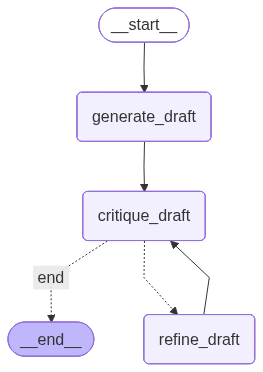

In [33]:
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
initial_state = {
    "draft": "",
    "critique": "",
    "loop_count": 0,
    "revisions": [],
    "done": False,
}

In [35]:
result = app.invoke(initial_state)

In [36]:
# ---- Display Final Output ----
print("\n✅ Final Refined Blog Post:\n")
print(result["draft"])


✅ Final Refined Blog Post:

**The Importance of Creativity in AI: Unlocking New Possibilities**

In today's rapidly evolving technological landscape, artificial intelligence (AI) is emerging as a powerful force, not only in data processing but in the realm of creativity. Once considered the domain of artists and innovators, creativity in AI is redefining how these systems can address complex challenges and drive innovation.

Picture AI that transcends mere data analysis to generate art, compose music, and devise unique solutions to intricate problems. This imaginative capacity transforms AI from a simple tool into a valuable collaborator. For instance, generative AI aids filmmakers in crafting engaging scripts, assists architects in envisioning revolutionary designs, and even facilitates scientific discoveries by proposing original hypotheses. By harnessing this creative potential, AI enhances human imagination, leading to remarkable outcomes achievable only through collaboration.

Th

In [37]:
print("\n🪞 Reflection Loop Summary:")
print(f"Total Iterations: {result['loop_count']}")


🪞 Reflection Loop Summary:
Total Iterations: 3


In [38]:
print("\n🔁 Revision History:\n")
for i, rev in enumerate(result["revisions"], 1):
    print(f"--- Revision {i} ---\n{rev}\n")


🔁 Revision History:

--- Revision 1 ---
**The Importance of Creativity in AI: Unlocking New Possibilities**

In an era defined by rapid technological advancements, the spotlight on artificial intelligence (AI) is brighter than ever. But beyond algorithms and data processing lies a facet of AI that often goes unnoticed: creativity. While traditionally deemed the realm of artists and visionaries, creativity in AI is not just desirable; it’s essential for innovation and problem-solving.

Imagine AI systems that not only analyze data but also generate art, compose music, or devise novel solutions to complex challenges. This creative potential propels AI beyond rote tasks, allowing it to function as a collaborative partner. For instance, generative AI can assist filmmakers in script development, help architects envision groundbreaking designs, or even drive scientific discovery by proposing unique hypotheses. By harnessing the power of creativity, AI amplifies human imagination, resulting 